# Music Recomendations

In this project you will make an unsupervised system for music recommendations based on a song.

All of the data given to you is from Spotify. For definitions of some of the columns see https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features. The dataset has been partially processed to remove very unusual artists.

You will need to go through the entire machine learning process but for unsupervised learning (including big picture, exploration, ...). You will *not* split off a training and testing set. Also, you will not use cross-validation (see an example in a class notebook on how to convince `GridSearchCV` to not use CV). The ultimate goal is to be able to find which 'group' an audio track (which can be music, audio books, or other recordings) belongs to. We also want to make sure that none of the clusters are too small (so that if we ask for a related song, there is a significant amount of variability in the song that we get).

To help with making good clusters, you should form clusters for the artists and then integrate that information into each track's data. As with all preprocessing, you should try with and without this step (along with different clusterings of artists).


## Notes

### Artists Feature

The feature `artists` is actually a series of Python lists. To use them is a bit hard, but here are a few examples:
  * Get the length of the list for each row:  
    `data.artists.str.len()`
  * Get the first element of the list for each row:  
    `data.artists.apply(lambda artists:artists[0])`
  * Get the second element of the list for each row, or None if there is only one:   
    `data.artists.apply(lambda artists:artists[1] if len(artists) > 1 else None)`
  * To transform each artist in the list based on a dictionary named `trans` that has keys that are artists:  
    `data.artists.apply(lambda artists:(trans[artist] for artist in artists))`
  * To get the most common value from each list (once converted into something like numbers):  
    `data.artists.apply(statistics.mode)`
  * To make the list into multiple columns (filled with `None` for rows with fewer than max artists):  
    `pd.DataFrame({f'artists_{i}':data.artists.apply(lambda artists:artists[i] if len(artists) > i else None) for i in range(data.artists.str.len().max())})`

Also, other methods like `explode()` may be useful.


### Scoring

To be able to evaluate our model, we will need to use a custom scorer that can be used with `GridSearchCV` and `RandomSearchCV` that prefers clusters that contain pairs used by people in their personal playlists. This playlist data is in the `pairs` data. **This dataset must only be used for scoring.** Additionally, the scorer greatly penalizes having clusters that have less than 200 songs.

An example of using it is like:

```python
GridSearchCV(..., scoring=MusicScorer(data, pairs), ...)
```

where `data` and `pairs` are the full dataset and the pairs dataset from `load_data()`.


### Manual Testing

The function `recommendations()` can be used to perform manual testing. It can be called like:

```python
recommendations(data, clusters, ["50woGYhAqV3KXvO1LG4zLg", "6pmuu4qSz2WrtGkBjUfyuz", "3dmqIB2Qxe2XZobw9gXxJ6"])
```

where `data` is a `DataFrame` of all of the tracks (minimally the track ids) and `clusters` is a sequence of cluster numbers that line up with `data`.

In [1]:
import ast

import numpy as np
import scipy.sparse
import pandas as pd
#from mpl_toolkits import mplot3d 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer




In [2]:
#%matplotlib widget

In [3]:
def load_data():
    """
    Returns the track data, the artist data, and which pairs of tracks show up
    together in playlists. The pairs dataset is extremely large but used as a
    sparse matrix. It cannot be directly used.
    """
    data = pd.read_csv('data.csv', converters={'artists':ast.literal_eval})
    artists = pd.read_csv('artists.csv')
    tracks = np.unique(data.id)
    pairs = pd.DataFrame.sparse.from_spmatrix(scipy.sparse.load_npz('track_pairs.npz'), index=tracks, columns=tracks)
    return data, artists, pairs


def music_score(data, clusters, pairs):
    """
    Scores a set of clusters based on the track data, the clusters they are assigned to,
    and the pairs data.
    """
    summation = 0
    n_clusters = clusters.max()
    for i in range(n_clusters):
        tracks = data.id[clusters == i]
        sub = pairs.loc[tracks, tracks]
        denominator = len(tracks)
        if denominator < 200:
            denominator = (200*200*200*200)/(denominator*denominator*denominator)
        summation += sub.values.sum() / denominator
    return summation / n_clusters


class MusicScorer:
    """
    This is the actual scorer 'function' to use with `GridSearchCV`.
    It is used like:

    GridSearchCV(..., scoring=MusicScorer(data, pairs), ...)

    where `data` and `pairs` are the full dataset and the pairs
    dataset from `load_data()`.
    """

    def __init__(self, data, pairs):
        self.data = data
        self.pairs = pairs

    def __call__(self, estimator, X, y=None):
        # Get the cluster labels
        if hasattr(estimator, 'labels_'):
            labels = estimator.labels_
        elif hasattr(estimator, 'predict'):
            labels = estimator.predict(X)
        else:
            labels = estimator.fit_predict(X)

        # Compute the score
        return music_score(self.data, labels, self.pairs)


def recommendations(all_tracks, clusters, tracks, recommendations_per=5):
    """
    Given the complete data set (`all_tracks` is a DataFrame of track data or is
    a series/array of track ids) along with the `clusters` they belong to (a
    series/array of cluster numbers), lookup the given tracks (by their ids only),
    and return the number of recommendations per each of those tracks.

    If this is given a single track (as a string), this will return a single set
    of rows from `all_tracks`. If given a list of tracks (as a list of strings),
    this will return a list of sets of rows from `all_tracks`. The number of rows
    in each set is based on recommendations_per.
    """
    # force types
    full_data = len(all_tracks.shape) == 2
    all_tracks = pd.DataFrame(all_tracks) if full_data else pd.Series(all_tracks)
    all_tracks = all_tracks.reset_index(drop=True)
    clusters = pd.Series(clusters).reset_index(drop=True)
    single = isinstance(tracks, str)
    if single: tracks = [tracks]

    # get each track's cluster
    matches = all_tracks.id.isin(tracks) if full_data else all_tracks.isin(tracks)
    cluster_nums = clusters[matches]

    # sample from each cluster
    if single:
        return all_tracks.loc[clusters[clusters == cluster_nums.iloc[0]].sample(recommendations_per).index]
    return [all_tracks.loc[clusters[clusters == cluster].sample(recommendations_per).index] for cluster in cluster_nums]


# Frame the Problem and Look at the Big Picture 
1. Define the objective in business terms. 
    The objective is to make a machine learning model that will give music recommendations based on a song. 
2. How will your solution be used? 
    The solution will be used by users of spotify to get song recommendations based on the songs that they are listening to. 
3. What are the current solutions/workarounds (if any)? 
    Apple music uses a similar model to give recommendations.
4. How should you frame this problem (supervised/unsupervised, online/offline, ...)? 
    This problem is an unsupervised, offline clustering problem.
5. How should performance be measured? Is the performance measure aligned with the business objective? 
    The performance will be measured using the custom scorer called MusicScorer() using the pairs dataset.
6. What would be the minimum performance needed to reach the business objective?
    # Each cluster must have more than 200 songs.
7. What are comparable problems? Can you reuse experience or tools? 
    # A comparable problem would be clustering handwritten digets. We could reuse some code from that document with some modifications.
8. Is human expertise available? 
    Human expertise is not availible.
9. How would you solve the problem manually? 
    Recommend popular songs in the same genre. 
10.  List the assumptions you (or others) have made so far. Verify assumptions if possible. 
    - The recommended song must be on Spotify.
    # Add more here

# Get the Data 
1. List the data you need and how much you need 
    The data needed is songs and artists from Spotify, including their names, artist, genre, etc.
2. Find and document where you can get that data 
    Document was given to us by the client. It was taken from the Spotify API.
3. Get access authorizations 
    Permission recieved by the client.
4. Create a workspace (with enough storage space) 
    This notebook and repository on github.
5. Get the data
    Data was recieved by the client.
6. Convert the data to a format you can easily manipulate (without changing the data itself) 
    Data was formatted into 3 pandas dataframes.
7. Ensure sensitive information is deleted or protected (e.g. anonymized)
    There is no sensitive information that needs to be protected or anonymized.
8. Check the size and type of data (time series, geographical, ...) 
    The data dataframe has 61013 data points and 18 different features:
    
        id: object 
        name: object 
        artists: object 
        year: int64  
        duration_ms: int64  
        explicit: int64  
        popularity: int64  
        key: int64  
        mode: int64  
        tempo: float64
        loudness: float64
        acousticness: float64
        danceability: float64
        energy: float64
        instrumentalness: float64
        liveness: float64
        speechiness: float64
        valence: float64
        
    The artists dataframe has 6702 data points and 12 features:

        artist: object 
        count: int64  
        popularity: float64
        tempo: float64
        loudness: float64
        acousticness: float64
        danceability: float64
        energy: float64
        instrumentalness: float64
        liveness: float64
        speechiness: float64
        valence: float64
        
9. Sample a test set, put it aside, and never look at it (no data snooping!) 
    This is not applicable to unsupervised learning.

In [4]:
data, artists, pairs = load_data()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61013 entries, 0 to 61012
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                61013 non-null  object 
 1   name              61013 non-null  object 
 2   artists           61013 non-null  object 
 3   year              61013 non-null  int64  
 4   duration_ms       61013 non-null  int64  
 5   explicit          61013 non-null  int64  
 6   popularity        61013 non-null  int64  
 7   key               61013 non-null  int64  
 8   mode              61013 non-null  int64  
 9   tempo             61013 non-null  float64
 10  loudness          61013 non-null  float64
 11  acousticness      61013 non-null  float64
 12  danceability      61013 non-null  float64
 13  energy            61013 non-null  float64
 14  instrumentalness  61013 non-null  float64
 15  liveness          61013 non-null  float64
 16  speechiness       61013 non-null  float6

In [6]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            6702 non-null   object 
 1   count             6702 non-null   int64  
 2   popularity        6702 non-null   float64
 3   tempo             6702 non-null   float64
 4   loudness          6702 non-null   float64
 5   acousticness      6702 non-null   float64
 6   danceability      6702 non-null   float64
 7   energy            6702 non-null   float64
 8   instrumentalness  6702 non-null   float64
 9   liveness          6702 non-null   float64
 10  speechiness       6702 non-null   float64
 11  valence           6702 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 628.4+ KB


# Explore the Data 
1. Copy the data for exploration, downsampling to a manageable size if necessary. 
2. Study each attribute and its characteristics: Name; Type (categorical, numerical, 
bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); 
Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...) 
3. For supervised learning tasks, identify the target attribute(s) 
    Not applicable in this task. (Unsupervised)
4. Visualize the data 
5. Study the correlations between attributes 
6. Study how you would solve the problem manually 
7. Identify the promising transformations you may want to apply 
8. Identify extra data that would be useful (go back to “Get the Data”) 
9. Document what you have learned 
    Done Above.

In [7]:
data_copy = data.copy()
artists_copy = data.copy()

In [8]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61013 entries, 0 to 61012
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                61013 non-null  object 
 1   name              61013 non-null  object 
 2   artists           61013 non-null  object 
 3   year              61013 non-null  int64  
 4   duration_ms       61013 non-null  int64  
 5   explicit          61013 non-null  int64  
 6   popularity        61013 non-null  int64  
 7   key               61013 non-null  int64  
 8   mode              61013 non-null  int64  
 9   tempo             61013 non-null  float64
 10  loudness          61013 non-null  float64
 11  acousticness      61013 non-null  float64
 12  danceability      61013 non-null  float64
 13  energy            61013 non-null  float64
 14  instrumentalness  61013 non-null  float64
 15  liveness          61013 non-null  float64
 16  speechiness       61013 non-null  float6

All of the features except <mark>id, name, and artists</mark> are numerical features. <mark>id</mark> is a categorical feature that makes each song unique. <mark>name</mark> and <mark>artists</mark> are textual features that defines the song. By this analysis, using the <mark>OrdinalEncoder</mark> will use there to convert text into integer array. Also, there are multiple songs that can be written by the same artist. 

<AxesSubplot:>

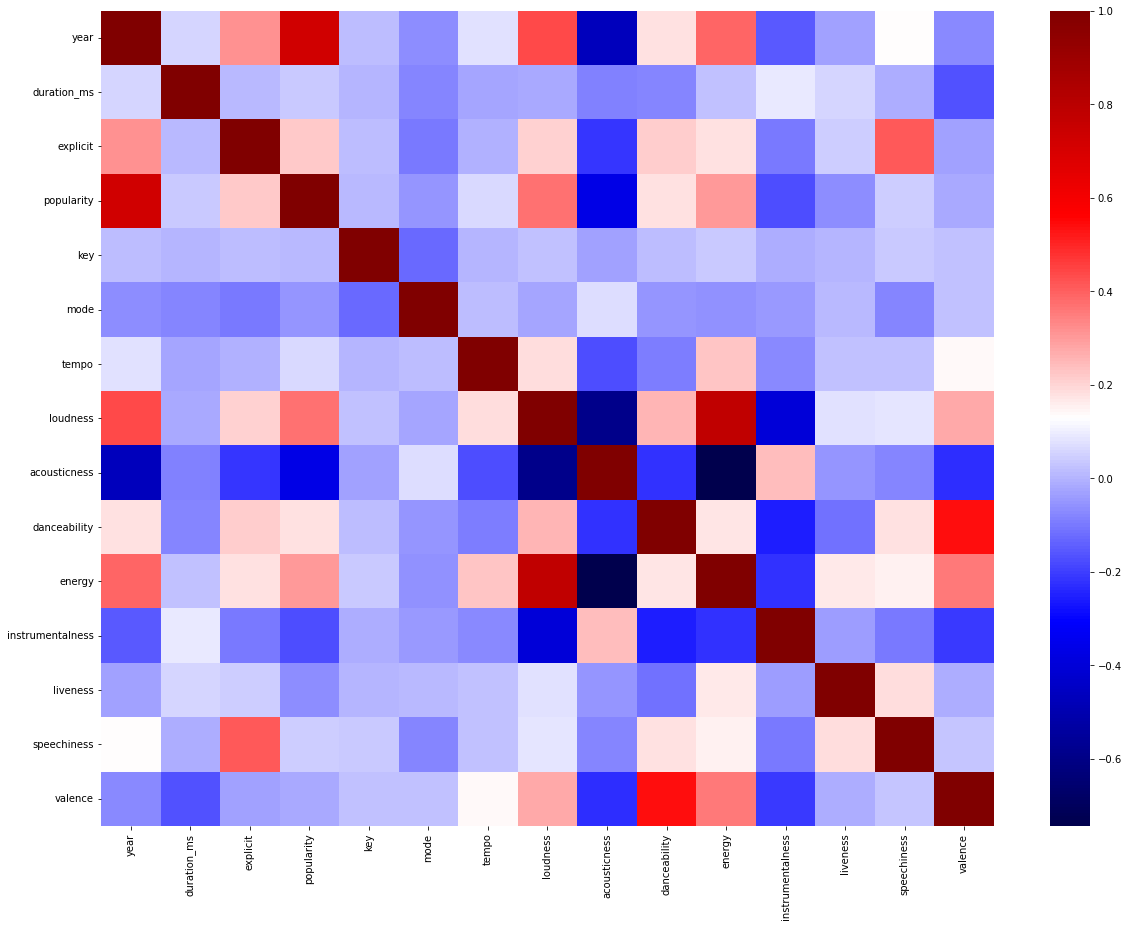

In [9]:
plt.figure(figsize=(20, 15))
sns.heatmap(data_copy.corr(), cmap='seismic')

Based on the heatmap, we can see that there are multiple features that have high positive correlations. 
High Positive Correlation
- energy and loudness
- year and popularity 
- valence and danceability



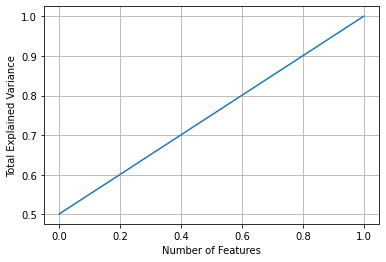

In [11]:
pipeline = Pipeline(steps=[
    ('ColumnTransformer', ColumnTransformer(transformers=[
        ('OrdinalEncoding',OrdinalEncoder(), ['id','name'])
    ])),
    ('Standard_scaler', StandardScaler()),
    ('PCA', PCA()),    
])
pipeline.fit(data_copy)
plt.figure()
plt.plot(pipeline.named_steps.PCA.explained_variance_ratio_.cumsum())
plt.xlabel("Number of Features")
plt.ylabel("Total Explained Variance")
plt.grid()